<a href="https://colab.research.google.com/github/gabrieladamasceno/Attacks_5G/blob/main/MLP_Bin%C3%A1rio_Zero_Day.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Acessar dataset
drive.mount('/content/gdrive')

# Carregar o dataset
encoded = pd.read_csv("/content/gdrive/MyDrive/Datasets/Attacks/Encoded/Encoded.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [47]:
pip install imbalanced-learn


In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


In [49]:
# Usando shape
num_amostras = encoded.shape[0]
print(f"Número de amostras: {num_amostras}")

# Usando len()
num_amostras_len = len(encoded)
print(f"Número de amostras (usando len): {num_amostras_len}")

Número de amostras: 1215890
Número de amostras (usando len): 1215890


In [50]:
# Exibir os nomes de todas as colunas
colunas = encoded.columns.tolist()  # Converte o Index em uma lista
print("Nomes das colunas:")
for coluna in colunas:
    print(coluna)

Nomes das colunas:
Unnamed: 0
Seq
Dur
RunTime
Mean
Sum
Min
Max
sTos
dTos
sTtl
dTtl
sHops
dHops
TotPkts
SrcPkts
DstPkts
TotBytes
SrcBytes
DstBytes
Offset
sMeanPktSz
dMeanPktSz
Load
SrcLoad
DstLoad
Loss
SrcLoss
DstLoss
pLoss
SrcGap
DstGap
Rate
SrcRate
DstRate
SrcWin
DstWin
sVid
dVid
SrcTCPBase
DstTCPBase
TcpRtt
SynAck
AckDat
Label
Attack Type
Attack Tool
 *        
 *    V   
 *    f   
 e        
 e    f   
 e &      
 e *      
 e d      
 e g      
 e i      
 e r      
 e s      
 eU       
e        
arp
icmp
ipv6-icmp
llc
lldp
sctp
tcp
udp
ACC
CON
ECO
FIN
INT
NRS
REQ
RSP
RST
TST
URP
Shutdown
Start
Status
39
4
52
54
af11
af12
af41
cs0
cs4
cs6
cs7
ef
nan


In [51]:
# Selecionar apenas colunas numéricas
numeric_cols = encoded.select_dtypes(include=['number']).columns

# Aplicar a suavização apenas nas colunas numéricas
for col in numeric_cols:
    encoded[col] = encoded[col].fillna(encoded[col].mean())

In [52]:
# columns with null values

columns_null = []
columns = encoded.columns
for column in columns:
    c = encoded[column].isnull().sum()
    if c != 0:
        print(column, 'has {} null values'.format(c))
        columns_null.append(column)

In [67]:
pip install tensorflow==2.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 37.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: 

Features
* Seq: Sequência de pacotes.
* Offset: Deslocamento em bytes.
* sTtl: Time to Live da fonte.
* tcp: Indica se o protocolo TCP está sendo usado.
* AckDat: Dados de reconhecimento.
* RST: Sinalizador de reinício TCP.
* INT: Interrupções no fluxo de dados.
* TcpRtt: Tempo de ida e volta do TCP.
* icmp: Indica se o protocolo ICMP está presente.
* sMeanPktSz: Tamanho médio do pacote da fonte.
* FIN: Sinalizador de finalização de conexão.
* sHops: Número de saltos até o destino.
* Mean: Valor médio de um conjunto de dados.
* dTtl: Time to Live do destino.
* SrcBytes: Bytes enviados da fonte.
* TotBytes: Total de bytes.
* dMeanPktSz: Tamanho médio do pacote do destino.
* Status: Estado da conexão.
* cs0: Parâmetro de controle.
* SrcWin: Janela de origem TCP.
* sTos: Tipo de serviço.
* CON: Conexões.
* REQ: Requisições.
* Loss: Taxa de perda de pacotes.

In [79]:
import psutil
import time
from keras.callbacks import Callback

# Função para monitorar recursos
def monitor_resource_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    cpu_percent = psutil.cpu_percent(interval=0.1)
    memory_usage_mb = memory_info.rss / (1024 * 1024)
    return cpu_percent, memory_usage_mb

# Callback personalizado para monitorar CPU e memória
class ResourceMonitor(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        # Antes da época começar
        self.start_time = time.time()
        self.start_cpu, self.start_memory = monitor_resource_usage()
        print(f"\n[Início da Época {epoch + 1}]")
        print(f"CPU inicial: {self.start_cpu:.2f}%, Memória inicial: {self.start_memory:.2f} MB")

    def on_epoch_end(self, epoch, logs=None):
        # Após a época terminar
        end_time = time.time()
        end_cpu, end_memory = monitor_resource_usage()
        elapsed_time = end_time - self.start_time
        memory_diff = end_memory - self.start_memory

        print(f"[Fim da Época {epoch + 1}]")
        print(f"CPU final: {end_cpu:.2f}%, Memória consumida: {memory_diff:.2f} MB, Tempo gasto: {elapsed_time:.2f} segundos")

# Instanciar o callback
resource_monitor = ResourceMonitor()

In [131]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

# Parâmetros para early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# **PASSO 1: Configuração das features e rótulos**
features = [
    'Seq', 'Offset', 'sTtl', 'tcp', 'AckDat', 'RST', 'INT', 'TcpRtt', 'icmp',
    'sMeanPktSz', 'FIN', 'sHops', 'Mean', 'dTtl', 'SrcBytes', 'TotBytes',
    'dMeanPktSz', 'Status', 'cs0', 'SrcWin', 'sTos', 'CON', 'REQ', 'Loss'
]
X = encoded[features]
y = encoded['Label']  # Coluna de rótulos

# Passo 1: Filtrar as amostras zero-day (ICMPFlood)
zero_day_data = encoded[encoded['Attack Type'] == 'ICMPFlood']
non_zero_day_data = encoded[encoded['Attack Type'] != 'ICMPFlood']

# Passo 2: Dividir o conjunto não-zero-day (benignos e maliciosos) para treinamento
X_non_zero_day = non_zero_day_data[features]
y_non_zero_day = non_zero_day_data['Label']

# Dividir o conjunto de treino e teste (sem zero-day no treino)
X_train_non_zero_day, X_test_non_zero_day, y_train_non_zero_day, y_test_non_zero_day = train_test_split(
    X_non_zero_day, y_non_zero_day, test_size=0.3, random_state=42, stratify=y_non_zero_day
)

# Passo 3: Concatenar as amostras zero-day no conjunto de teste (com rótulo de malicioso - 1)
X_test_combined = np.concatenate([X_test_non_zero_day, zero_day_data[features].values])
y_test_combined = np.concatenate([y_test_non_zero_day, np.ones(len(zero_day_data))])  # 1 para malicioso (zero-day é considerado malicioso)

# **PASSO 4: Garantir que 'y_test_combined' seja binário**
# Se 'Benign' for encontrado, mapeie para 0, caso contrário, mapeie para 1 (para Malicious)
y_test_combined = [0 if label == 'Benign' else 1 for label in y_test_combined]

# Garantir que 'y_test_combined' é um array de inteiros
y_test_combined = np.array(y_test_combined, dtype=int)

# **PASSO 5: Garantir que as amostras zero-day estão no conjunto de teste**
print(f"Zero-day presente no conjunto de teste: {'ICMPFlood' in zero_day_data['Attack Type'].values}")

# Verificar a distribuição das classes no conjunto de teste
unique_labels_test = np.unique(y_test_combined)
print(f"Distribuição de classes no conjunto de teste: {unique_labels_test}")

# Verificar se as amostras zero-day estão no conjunto de teste
zero_day_in_test = np.any(y_test_combined == 1)  # Zero-day foi atribuído rótulo 1 (malicioso)
print(f"Zero-day presente no conjunto de teste (rótulo malicioso): {zero_day_in_test}")

# **PASSO 6: Converter para binário (Benign = 0, Malicious = 1, mantendo zero-day no teste com rótulo original)**
y_train_binary = [0 if label == 'Benign' else 1 for label in y_train_non_zero_day]  # 0 para Benign, 1 para Malicious
y_test_binary = [
    0 if label == 'Benign' else 1 for label in y_test_combined  # 0 para Benign, 1 para Malicious
]  # Mantendo zero-day sem mudar o rótulo

# Verificar a distribuição das classes no conjunto de teste
unique_labels_test = np.unique(y_test_combined)
print(f"Distribuição de classes no conjunto de teste (binário): {unique_labels_test}")

# **PASSO 7: Garantir que X_train_non_zero_day e X_test_combined sejam DataFrames antes de usar o StandardScaler**
X_train_non_zero_day = pd.DataFrame(X_train_non_zero_day, columns=features)
X_test_combined = pd.DataFrame(X_test_combined, columns=features)

# Ajustar o scaler com os DataFrames completos
scaler = StandardScaler()
X_train_non_zero_day = scaler.fit_transform(X_train_non_zero_day)
X_test_combined = scaler.transform(X_test_combined)

# Verificar as distribuições
print("Distribuição do conjunto de treino binário:", pd.Series(y_train_binary).value_counts())
print("Distribuição do conjunto de teste binário:", pd.Series(y_test_binary).value_counts())

# Agora você pode verificar a distribuição das classes no conjunto de teste
unique_labels_test = np.unique(y_test_combined)
print(f"Distribuição de classes no conjunto de teste (binário): {unique_labels_test}")

Zero-day presente no conjunto de teste: True
Distribuição de classes no conjunto de teste: [0 1]
Zero-day presente no conjunto de teste (rótulo malicioso): True
Distribuição de classes no conjunto de teste (binário): [0 1]
Distribuição do conjunto de treino binário: 1    515898
0    334416
Name: count, dtype: int64
Distribuição do conjunto de teste binário: 1    365576
Name: count, dtype: int64
Distribuição de classes no conjunto de teste (binário): [0 1]


In [132]:
# Verifique as formas de X_train_smote e y_train_smote
print(X_train_smote.shape)
print(y_train_smote.shape)

# Verifique se os dados de teste também têm as dimensões corretas
print(X_test_non_zero_day.shape)
print(len(y_test_combined))

(1031796, 24)
(1031796,)
(364421, 24)
365576


In [133]:
# **PASSO 9: Construir e treinar o modelo**
model = Sequential()
model.add(Input(shape=(X_train_smote.shape[1],)))
model.add(Dense(96, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid'))

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(
    X_train_smote, y_train_smote,
    validation_data=(X_test_non_zero_day, y_test_combined),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, resource_monitor]
)

# **PASSO 10: Previsões e avaliação**
y_pred = (model.predict(X_test_non_zero_day) > 0.5).astype(int)

# Avaliação geral
print("Relatório de classificação (geral):")
print(classification_report(y_test_combined, y_pred))

# **PASSO 11: Avaliar desempenho nos casos zero-day**
# Identificar os ataques zero-day no conjunto de teste
X_test_zero_day = zero_day_data[features]
y_test_zero_day = zero_day_data['Label'].map({'ICMPFlood': 2})  # Zero-day será marcado como '2'

# Normalizar os dados de teste zero-day
X_test_zero_day = scaler.transform(X_test_zero_day)

# Previsões para os casos zero-day
y_pred_zero_day = (model.predict(X_test_zero_day) > 0.5).astype(int)

# Relatório para zero-day
print("Relatório de classificação (casos zero-day):")
print(classification_report(y_test_zero_day, y_pred_zero_day))


[Início da Época 1]
CPU inicial: 0.00%, Memória inicial: 9645.19 MB
Epoch 1/10
32233/32244 [============================>.] - ETA: 0s - loss: 0.2287 - accuracy: 0.9824

ValueError: Data cardinality is ambiguous:
  x sizes: 364421
  y sizes: 365576
Make sure all arrays contain the same number of samples.

11399/11399 [==============================] - 13s 1ms/step


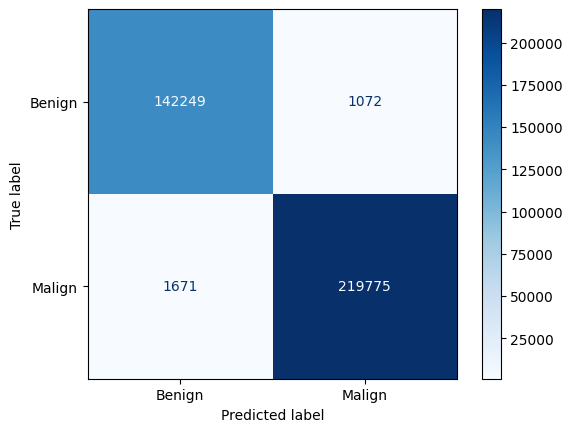

In [72]:
y_test = y_test_binary

#Matriz de Confusão

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)


cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malign"])
disp.plot(cmap='Blues')

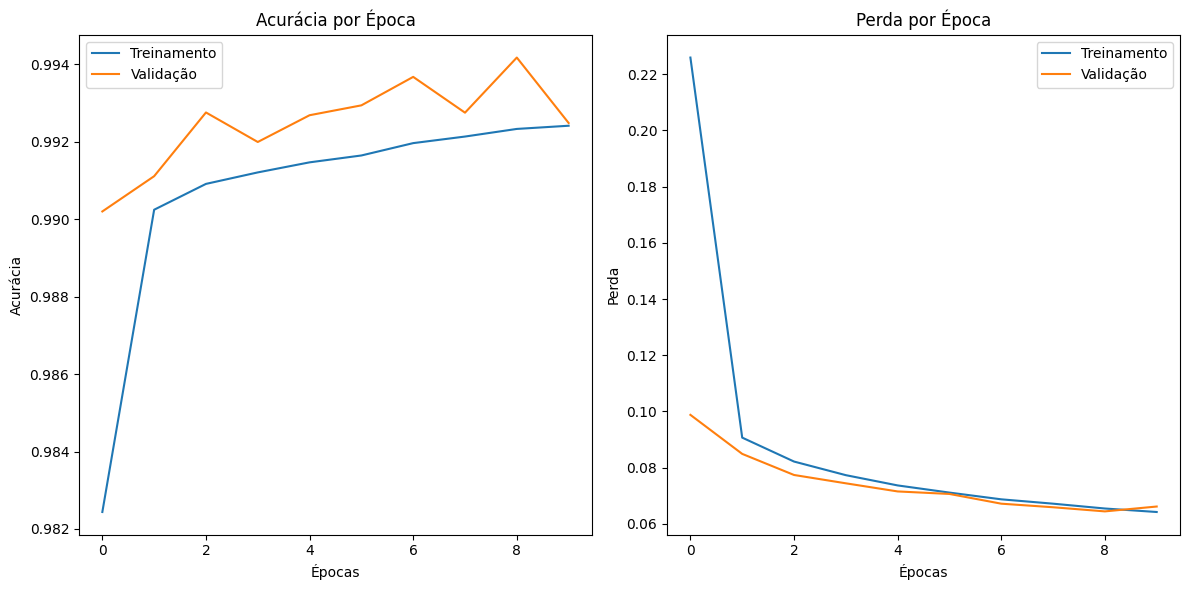

In [73]:
# Gráfico de Acurácia
plt.figure(figsize=(12, 6))

# Acurácia de treino
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia por Época')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

# Gráfico de Perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda por Época')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

In [74]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Supondo que 'model' seja seu modelo treinado
y_pred_prob = model.predict(X_test).flatten()  # Usando .flatten() para transformar em um vetor 1D

11399/11399 [==============================] - 13s 1ms/step


In [75]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

In [76]:
roc_auc = auc(fpr, tpr)

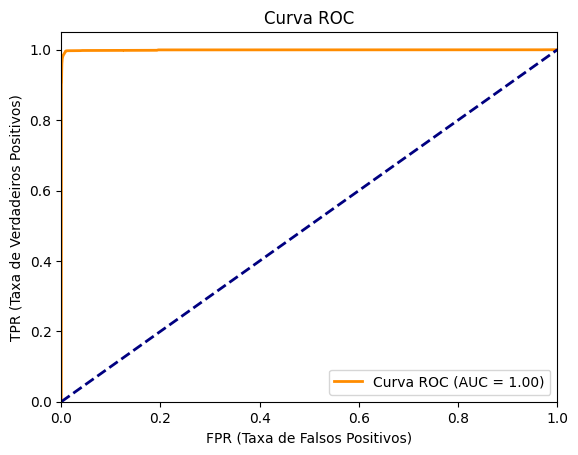

In [77]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calcular a AUC
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Linha diagonal (chance aleatória)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR (Taxa de Falsos Positivos)')
plt.ylabel('TPR (Taxa de Verdadeiros Positivos)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()